In [16]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Dimensionality Reduction: PCA

With automatic data collection and feature generation techniques, one can quickly obtain a large number of features.
But not all of them are useful. Not only does this make training extremely slow, it can also
make it much harder to find a good solution, as we will see. This problem is often
referred to as the *curse of dimensionality*.

We discussed filtering and feature scaling as ways of pruning away uninformative features. 
Now we will take a close look at the topic of feature dimensionality reduction using **principal component analysis** (PCA).


## Main Approaches for Dimensionality Reduction

Before we dive into specific dimensionality reduction algorithms, let’s take a look at the two main approaches to reducing dimensionality.

### Projection

In most real-world problems, training instances are not spread out uniformly across
all dimensions. Many features are almost constant, while others are highly correlated. 
As a result, all training instances actually lie within (or close to) a much lower-dimensional subspace of the high-dimensional space.

In [17]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

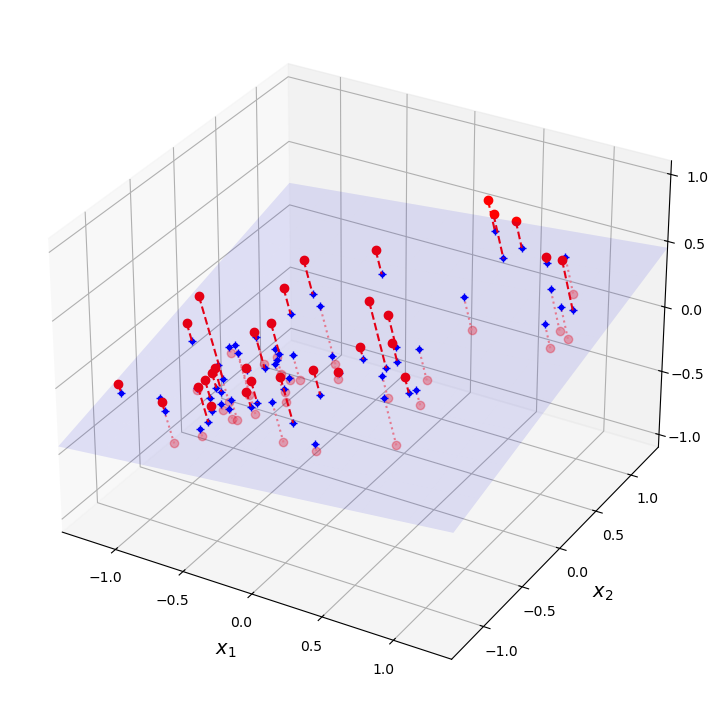

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

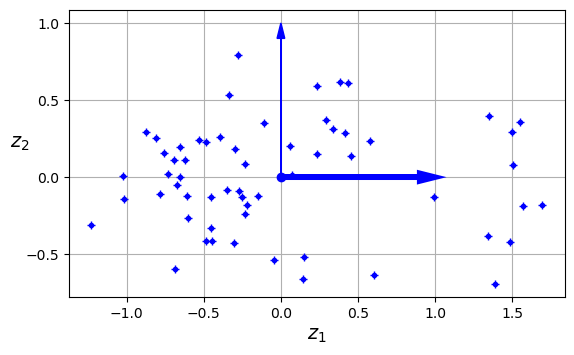

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
plt.show()

However, projection is not always the best approach to dimensionality reduction. 
In many cases the subspace may twist and turn, such as in the famous *Swiss roll* toy dataset

In [20]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1500, noise=0.2, random_state=42)



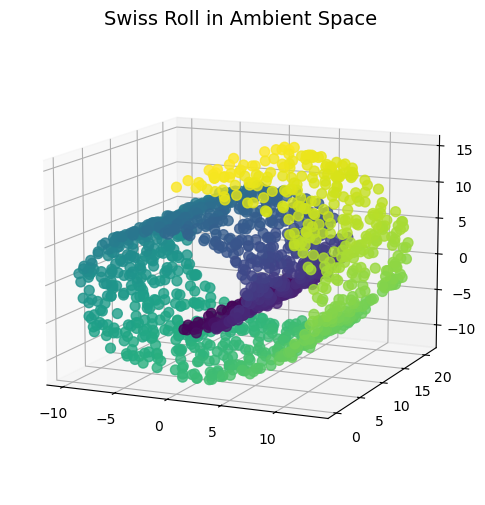

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, s=50, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)


### Manifold Learning

A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a
d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally
resembles a d-dimensional hyperplane. In the case of the Swiss roll, d = 2 and n = 3: it
locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which
the training instances lie; this is called Manifold Learning. It relies on the manifold
assumption, also called the manifold hypothesis, which holds that most real-world
high-dimensional datasets lie close to a much lower-dimensional manifold. This
assumption is very often empirically observed.

The manifold assumption is often accompanied by another implicit assumption: that
the task at hand (e.g., classification or regression) will be simpler if expressed in the
lower-dimensional space of the manifold.

However, this assumption does not always hold.

In short, if you reduce the dimensionality of your training set before training a
model, it will usually speed up training, but it may not always lead to a better or simpler
solution; it all depends on the dataset.


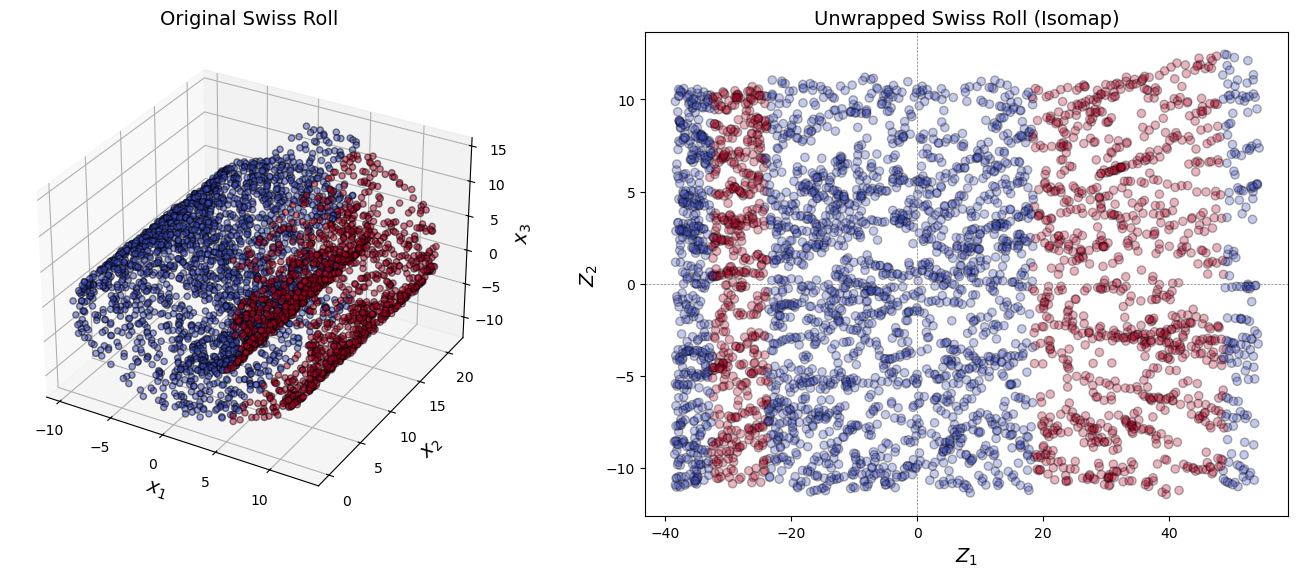

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

# Generate Swiss Roll dataset
n_samples = 4000
X, _ = make_swiss_roll(n_samples=n_samples, noise=0.1)

# Create class labels based on the plane x1 = 5
labels = (X[:, 0] > 5).astype(int)

# Apply Isomap for dimensionality reduction
isomap = Isomap(n_neighbors=10, n_components=2)
X_isomap = isomap.fit_transform(X)

# Create figure
fig = plt.figure(figsize=(14, 6))

# 1. Original Swiss Roll with class separation
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.5)
ax1.set_title("Original Swiss Roll ")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_zlabel("$x_3$")



# 2. Unwrapped Swiss Roll using Isomap with class separation
ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(X_isomap[:, 0], X_isomap[:, 1], c=labels, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.3)
ax2.set_title("Unwrapped Swiss Roll (Isomap)")
ax2.set_xlabel("$Z_1$")
ax2.set_ylabel("$Z_2$")
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

# Show the plots
plt.tight_layout()
plt.show()


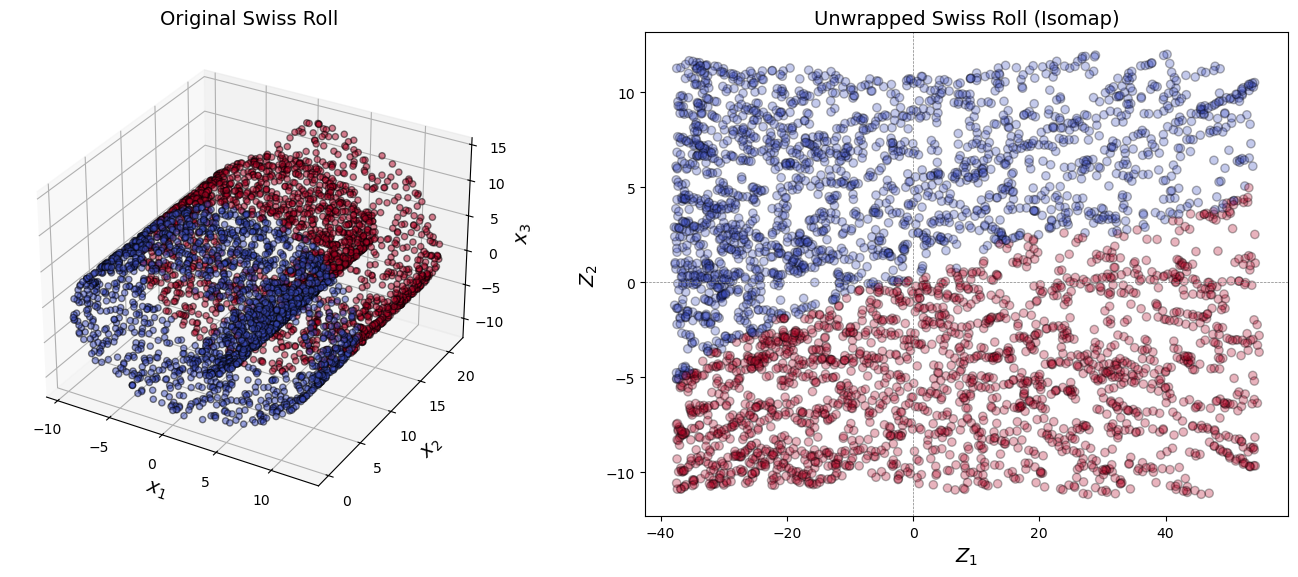

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

# Generate Swiss Roll dataset
n_samples = 4000
X, t = make_swiss_roll(n_samples=n_samples)

# Create class labels 
labels = (t + X[:, 1] > np.median(t + X[:, 1])).astype(int)

# Apply Isomap for dimensionality reduction
isomap = Isomap(n_neighbors=10, n_components=2)
X_isomap = isomap.fit_transform(X)

# Create figure
fig = plt.figure(figsize=(14, 6))

# 1. Original Swiss Roll with class separation
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.5)
ax1.set_title("Original Swiss Roll ")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_zlabel("$x_3$")



# 2. Unwrapped Swiss Roll using Isomap with class separation
ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(X_isomap[:, 0], X_isomap[:, 1], c=labels, cmap=plt.cm.coolwarm, edgecolor='k', alpha=0.3)
ax2.set_title("Unwrapped Swiss Roll (Isomap)")
ax2.set_xlabel("$Z_1$")
ax2.set_ylabel("$Z_2$")
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

# Show the plots
plt.tight_layout()
plt.show()


## PCA

PCA is by far the most popular dimensionality reduction algorithm and focuses on the notion of linear dependency. 

Linearly dependent features are a waste of space and computation power because the information could have been encoded in
much fewer features.

The key idea here is to replace redundant features with a few new features that adequately summarize information contained in the original feature space. 

### Preserving the Variance

One way to mathematically define “adequately summarize information” is
to say that Before you can project the training set onto a lower-dimensional hyperplane, you
first need to choose the right hyperplane, i.e., the one that will most likely lose less information.

It seems reasonable to select the axis that retain as much of the original volume
as possible. To measure volume, we could measure the maximum distance between any two pairs of points, but that turns out to be a very difficult function to mathematically optimize.
An alternative is to measure the average distance between pairs of points, or equivalently, the average distance between each point and its mean, which is the variance. This turns out to be much easier to optimize.

>Mathematically, this translates into maximizing the variance of the data points in the new feature space.

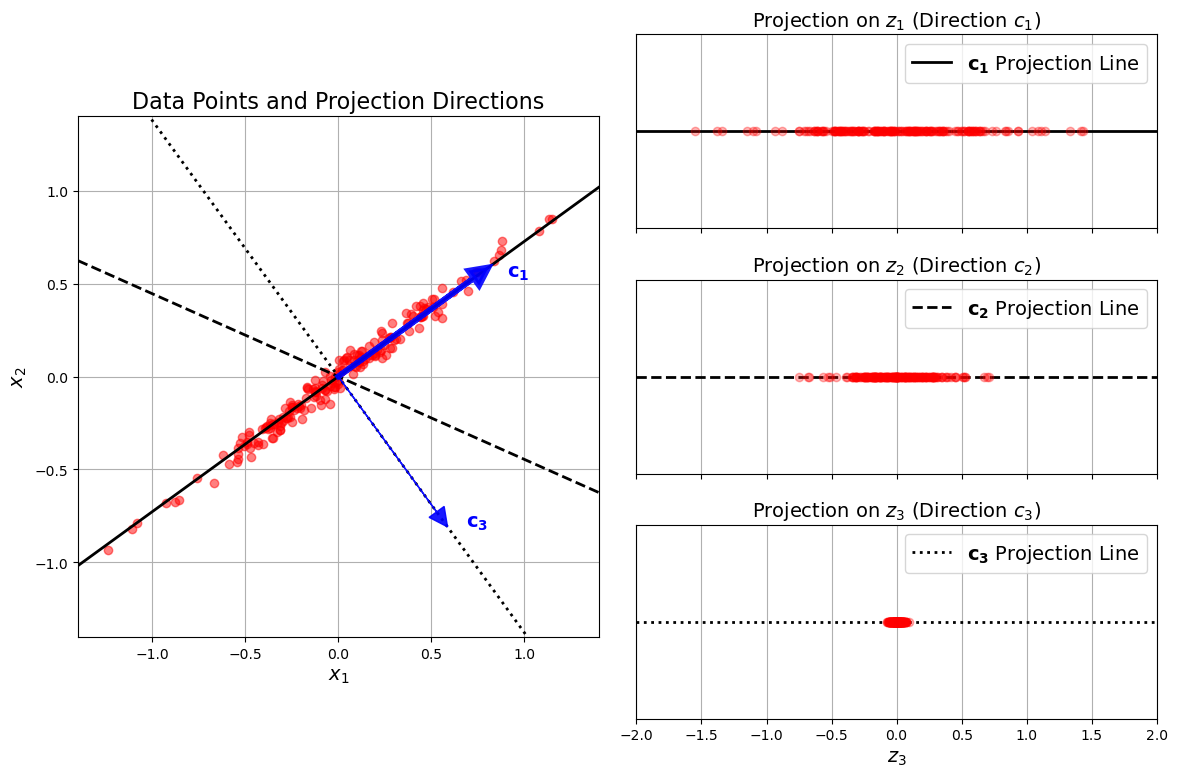

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
angle = np.pi / 5
stretch = 5
m = 200

# Generate random data
np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # Stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # Rotate

# Define projection directions
u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

# Project data onto the defined directions
X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

# Create the figure
plt.figure(figsize=(12, 8))

# 1. Scatter plot of the original data and projection directions (Square Aspect Ratio)
ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5, label='Data Points')
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)

# Plotting projection lines
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-", linewidth=2, label=r"$\mathbf{c_1}$ Direction")
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--", linewidth=2, label=r"$\mathbf{c_3}$ Direction")
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:", linewidth=2, label=r"$\mathbf{c_2}$ Direction")

# Annotations
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_3}$", color="blue")

# Labels and aesthetics
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.title("Data Points and Projection Directions", fontsize=16)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()
ax1.set_aspect('equal', adjustable='box')  # Set square aspect ratio

# 2. Projected data along u1
ax2 = plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2, label=r"$\mathbf{c_1}$ Projection Line")
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.title("Projection on $z_1$ (Direction $c_1$)", fontsize=14)
plt.grid()
plt.legend()

# 3. Projected data along u2
ax3 = plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2, label=r"$\mathbf{c_2}$ Projection Line")
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.title("Projection on $z_2$ (Direction $c_2$)", fontsize=14)
plt.grid()
plt.legend()

# 4. Projected data along u3
ax4 = plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2, label=r"$\mathbf{c_3}$ Projection Line")
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_3$", fontsize=14)
plt.title("Projection on $z_3$ (Direction $c_3$)", fontsize=14)
plt.grid()
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


### Principal Components

PCA identifies the axis that accounts for the largest amount of variance in the training
set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. 

In the previous 2D example there is no choice: it is the dotted line. 

If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on—as many axes as the number of dimensions in the dataset.

>The unit vector that defines the *i*th axis is called the *i*th principal component (PC). 

### Singular Value Decomposition

So how can we find the principal components of a training set?
The easiest way to implement PCA is by taking the **Singular Value Decomposition** (SVD) of the centered data matrix.

SVD is a standard matrix factorization technique that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U$, $\Sigma$, and $V^T$. where $V$ contains all the principal components that we are looking for:


$$ 
    V = \Bigg( c_1 \; c_2 \; \dots \; c_n \Bigg) 
$$


$U$ and $V$ are orthogonal matrices (i.e., $U^TU = I$ and $V^TV = I$). $\Sigma$ is a diagonal matrix containing the singular values of $X$, which can be positive, zero, or negative. 

In [25]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

>In principle, the SVD factorization algorithm returns three matrices, $U$, $\Sigma$ and $V$, where $U$ is an $m\times m$ matrix, $\Sigma$ is an $m\times n$ matrix, and $V$ is an $n\times n$ matrix. But the `svd()` function returns $U$, $s$ and $V^T$ instead. $s$ is the vector containing all the values on the main diagonal of the top $n$ rows of $\Sigma$. Since $\Sigma$ is full of zeros elsewhere, your can easily reconstruct it from $s$, like this:

In [26]:
# how to construct Σ from s
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

### Projecting Down to $k$ Dimensions

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to $k$ dimensions by projecting it onto the hyperplane defined by the first $k$ principal components. 
Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

To project the training set onto the hyperplane, you can simply compute the matrix
multiplication of the training set matrix $X$ by the matrix $V_k$, defined as the matrix
containing the first $k$ principal components (i.e., the matrix composed of the first $k$ columns of V):

$$
Z = X V_k = U\Sigma{}V^TV_k = U_k \Sigma_k
$$

In [27]:
W2 = Vt[:2].T
X2D = X_centered.dot(W2)

### PCA Implementation Summary 

| Step | Description |
|------|-------------|
| **1. Center the Data Matrix** | Center the data matrix $ C $ by subtracting the mean:  $ C = X - \mathbf{1}\mu^T $, where $ \mathbf{1} $ is a column vector of ones and $ \mu $ is the mean vector of the rows of $ X $. |
| **2. Compute the SVD** | Perform Singular Value Decomposition (SVD) on the centered data matrix $ C $: $ C = U\Sigma V^T $ |
| **3. Find Principal Components** | The first $ k $ principal components are the first $ k $ columns of $ V $, corresponding to the $ k $ largest singular values. |
| **4. Transform the Data** | The transformed data is given by the first $ k $ columns of $ U $. (For whitening, scale the vectors by the inverse of the singular values, ensuring they are nonzero.) |



### Using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
pca.components_

array([[ 4.85716767e-01, -5.09943009e-04,  8.74116103e-01],
       [ 8.67330075e-01, -1.24083900e-01, -4.82018389e-01]])

### Selecting principal components

When using PCA for dimensionality reduction, one must address the question of how many principal components ($k$) to use. Like all hyperparameters, this number can be tuned based on the quality of the resulting model. But there are also heuristics that do not involve expensive computational methods.

One possibility is to pick $k$ to account for a desired proportion of total variance. (This option is available in the scikit-learn package PCA.) The variance of the projection onto the *k*th component (also termed **explained variance ratio**) is:

$$ 
    || X\mathbf{v_k} ||^2 = ||\mathbf{u_k}\sigma_k||^2 = \sigma_k^2 
$$

which is the square of the *k*th-largest singular value of $X$

#### Selecting $k$ based on accounted variance

The ordered list of singular values of a matrix is called its spectrum. Thus, to determine how many components to use, one can perform a simple spectral analysis of the data matrix and pick the threshold that retains enough variance.

>So, to retain enough components to cover 80% of the total variance in the data, pick $k$ such that:
>
>$$ \frac{\Sigma_{i=1}^k \sigma_i^2}{\Sigma_{i=1}^d \sigma_i^2} \ge 0.8 $$

Unless, of course, we are reducing dimensionality for data visualization: in that case we will generally want to reduce the dimensionality down to 2 or 3.

In [29]:
pca.explained_variance_ratio_

array([0.39453645, 0.31930836])

The first dimension explains about 76% of the variance, while the second explains about 15%.

By projecting down to 2D, we lost about 9% of the variance:

In [30]:
1 - pca.explained_variance_ratio_.sum() 

0.28615518940413565

## Code example: MNIST dataset

In [31]:
from sklearn import datasets
from sklearn.decomposition import PCA

# Load the data
digits_data = datasets.load_digits()
n = len(digits_data.images)



image shape: (1797, 64)


The MNIST dataset contains images of handwritten digits. Each image is an 8x8 array of pixel values. We flatten these arrays into 1D vectors to prepare them for PCA.

### Applying PCA to the Dataset


In [ ]:
image_data = digits_data.images.reshape((n, -1))
print('image shape:', image_data.shape)

In this section, we fit PCA to the flattened image data, selecting enough components to explain at least 80% of the variance. We then examine the explained variance ratios to understand how much information is retained by the principal components.

In [32]:
# Fit a PCA transformer to the dataset.
# The number of components is automatically chosen to account for 
# at least 80% of the total variance.
pca_transformer = PCA(n_components=0.8)
pca_images = pca_transformer.fit_transform(image_data)
pca_transformer.explained_variance_ratio_

array([0.14890594, 0.13618771, 0.11794594, 0.08409979, 0.05782415,
       0.0491691 , 0.04315987, 0.03661373, 0.03353248, 0.03078806,
       0.02372341, 0.02272697, 0.01821863])

In [33]:
pca_transformer.explained_variance_ratio_.sum()

0.8028957761040316

In [35]:
# Groundtruth label of the number appearing in each image
labels = digits_data.target
labels

array([0, 1, 2, ..., 8, 9, 8])

### Visualizing PCA Results in 3D

Here, we create a 3D scatter plot of the PCA results. Each point is labeled with the corresponding digit, allowing us to visualize how the digits are distributed in the reduced-dimensional space.



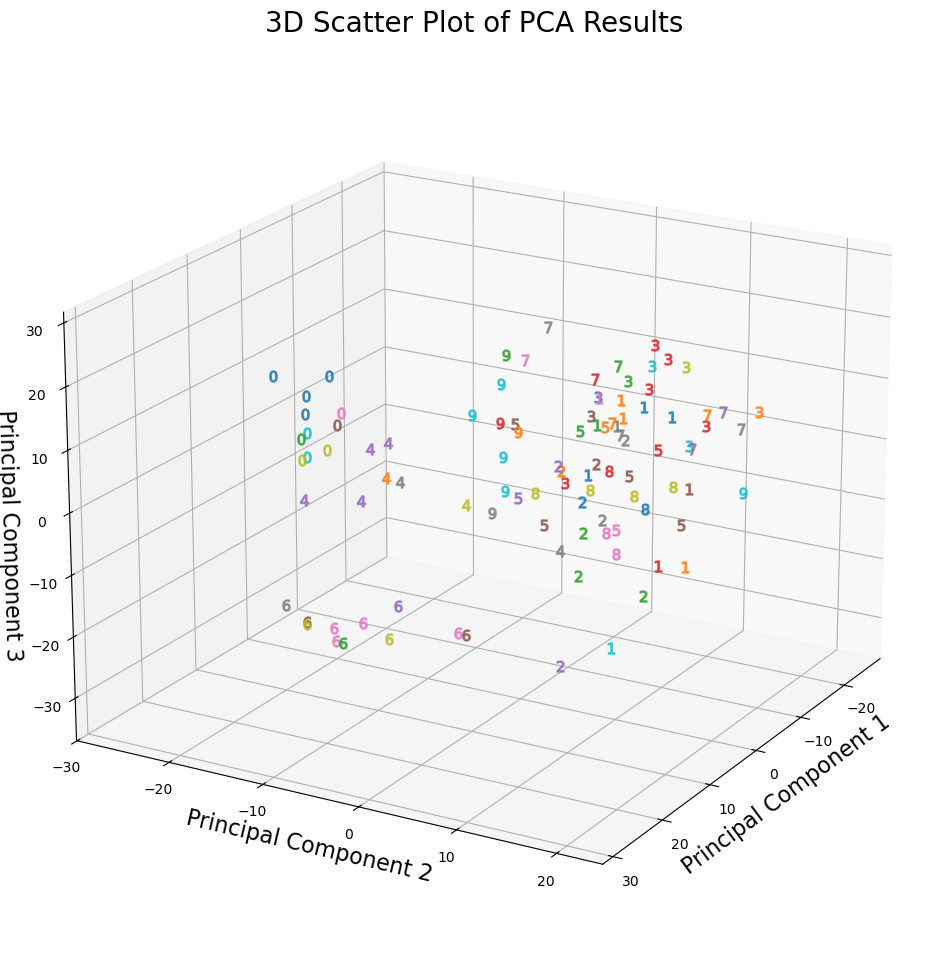

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure for the 3D scatter plot
fig = plt.figure(figsize=(12, 10))  # Increased figure size
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot with better aesthetics
for i in range(100):
    scatter = ax.scatter(pca_images[i,0], pca_images[i,1], pca_images[i,2],
                      marker=r'${}$'.format(labels[i]), s=64, alpha=0.7)

# Set axis labels with adjusted font size
ax.set_xlabel('Principal Component 1', fontsize=16)
ax.set_ylabel('Principal Component 2', fontsize=16)
ax.set_zlabel('Principal Component 3', fontsize=16)

# Set the title with adjusted font size
ax.set_title('3D Scatter Plot of PCA Results', fontsize=20)

# Adjust viewing angle for better visualization
ax.view_init(elev=20, azim=30)

# Show grid for better readability
ax.grid(True)

# Adjust layout to prevent text clipping
plt.tight_layout(w_pad=1.9)  # Leave space for the title

# Show the plot
plt.show()


### PCA for Compression

Next, we will see how PCA can be used for data compression by applying it to a higher resolution version of the MNIST dataset.
Obviously after dimensionality reduction, the training set takes up much less space.



First, Let's plot the cumulative explained variance against the number of dimensions or principal components. 

In [89]:
from sklearn.datasets import fetch_openml

# Let's use a MNIST dataset with higher resolution

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

# Here we take all components
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)


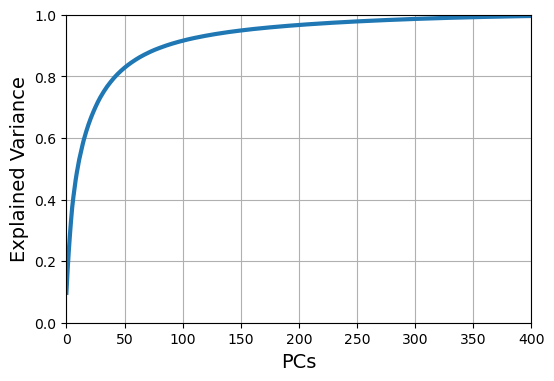

In [96]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("PCs")
plt.ylabel("Explained Variance")
plt.grid(True)

plt.show()

Now, we have to determine the optimal number of dimensions to retain in a dataset.

A heuristic method commonly used in dimensionality reduction is the **Elbow Method**.



The Elbow Method is based on the fact that as dimensions increase, the explained variance also rises, typically approaching 1. However, after a certain point, the increase in explained variance diminishes significantly, creating an "elbow" shape in the graph. The point at which this bend occurs signifies the ideal number of dimensions to retain, as it balances the trade-off between capturing sufficient variance and avoiding unnecessary complexity. 

By identifying this elbow point, practitioners can make informed decisions on how to reduce dimensionality effectively, ensuring that the most relevant features are preserved while simplifying the model for improved performance and interpretability.

Here we take only enough component to cover 95% of the variance.

In [94]:
pca = PCA(.95)
X_reduced = pca.fit_transform(X_train)
d = pca.n_components_
print("number of PCs: ", d)
print("preserved variance: ", pca.explained_variance_ratio_.sum() )

number of PCs:  154
preserved variance:  0.9501960192613034


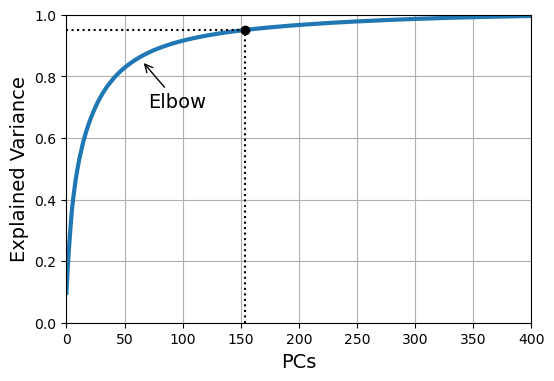

In [95]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("PCs")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)

plt.show()

Finally, we visualize a selection of original and reconstructed images side by side. This comparison demonstrates how PCA can effectively compress the data while still capturing the essential features necessary for reconstruction.


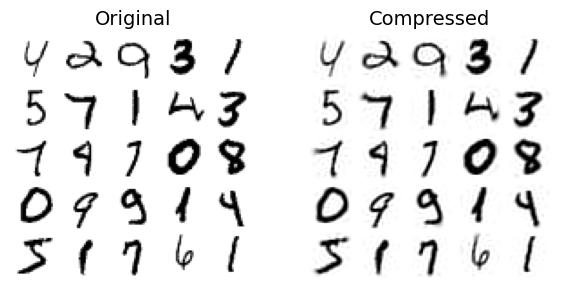

In [88]:
X_recovered = pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

plt.show()

In [98]:
def human_readable_size(size):
    """Convert a size in bytes to a human-readable format."""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024
    return f"{size:.2f} TB"  # for extremely large sizes


In [99]:
# Calculate the original size (number of pixels)
original_size = X_train.shape[0] * X_train.shape[1]  

# Calculate the compressed size
compressed_size = X_reduced.shape[0] * X_reduced.shape[1]  

# Calculate compression ratio
compression_ratio = original_size / compressed_size

print("Original size (pixels):", human_readable_size(original_size))
print("Compressed size (components):", human_readable_size(compressed_size))
print("Compression Ratio:", compression_ratio)


Original size (pixels): 44.86 MB
Compressed size (components): 8.81 MB
Compression Ratio: 5.090909090909091


### Limitations of PCA

While Principal Component Analysis (PCA) is a widely used technique for dimensionality reduction, it has several limitations that practitioners should be aware of:

- **Uninterpretable Outcome**: The principal components produced by PCA are linear combinations of the original features, which can make them difficult to interpret. This lack of interpretability can pose challenges when trying to understand the underlying structure or relationships in the data.

- **High Computational Cost**: The computation of PCA, especially for large datasets, can be resource-intensive. The algorithm involves matrix operations such as eigenvalue decomposition or Singular Value Decomposition (SVD), which can lead to significant computational overhead, particularly with high-dimensional data.

- **Challenges with Streaming Data**: PCA is typically performed on a static dataset, making it challenging to apply in situations where data is continuously generated or updated, such as in streaming applications. Adapting PCA to work with batch updates or samples from the full data can complicate the analysis and reduce the efficiency of the technique.

- **Sensitivity to Outliers**: PCA is sensitive to outliers, as they can disproportionately influence the direction of the principal components. This sensitivity can lead to misleading results, especially if the outliers are not appropriately handled prior to applying PCA.

These limitations underscore the importance of carefully considering the context and characteristics of the data when choosing PCA as a dimensionality reduction method, and they highlight the need for complementary techniques in data preprocessing and analysis.